In [96]:
#install.packages('randomForest')
library(readxl)
library(randomForest)
library(readxl)
library(tidyverse)
#install.packages('dplyr')
library(dplyr)
#install.packages('caret')
library(Rcpp)
library(caret)
library(rpart)
#install.packages('tree')
library(tree)
#install.packages('multcomp')
library(multcomp)
#install.packages('party')
library(party)
library(tree)
#install.packages('Metrics')
library(Metrics)
#install.packages('reprtree')
#devtools::install_github("MI2DataLab/randomForestExplainer")
#install.packages('randomForestExplainer')
library(randomForestExplainer)



Installing package into 'C:/Users/hichul/Documents/R/win-library/4.0'
(as 'lib' is unspecified)

also installing the dependency 'ranger'




package 'ranger' successfully unpacked and MD5 sums checked
package 'randomForestExplainer' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\hichul\AppData\Local\Temp\Rtmpio1VmN\downloaded_packages


Warning message:
"package 'randomForestExplainer' was built under R version 4.0.4"
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



# FA (weighted) Classifcation

In [18]:
df.wa = read_excel( "../../results/df-water-access.xlsx" ,sheet=1)
df.exp =read_excel("../../results/df-water-explore.xlsx" ,sheet=1)
df.cluster = read_excel("../../results/df-fa-cluster-rank.xlsx" ,sheet=1)
df.wb = read_excel("../../results/df-wb.xlsx" ,sheet=1 )
df.exp$clusters <- as.factor(df.cluster$clusters)


In [36]:
df <- merge(x = df.exp,
              y = df.wb,
              by = c("Country"))
df <- df[, c(1:8,11:17,19)]

ReScaling in Billions for GDP

In [37]:
df$cgdp <- paste(format(round(df$cgdp / 1e9, 1), trim = TRUE))


In [38]:
df$tpop <- paste(format(round(df$tpop / 1e6, 1), trim = TRUE)) # tpop in millions
df$land <- paste(format(round(df$land / 1e3, 1), trim = TRUE)) # land in thousands (sq. km)


In [39]:
df$prec <- paste(format(round(df$prec / 1e3, 1), trim = TRUE)) # Preciptiation depth in thousands of mm
head(df)

,Country,bicy,cart,mcyc,pcar,boat,wigc,clusters,cgdp,tpop,upop,popd,land,lita,lity,prec
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,Afghanistan,30.0,5.8,35.2,11.8,0.0,0.1,1,18.4,37.2,25.495,56.93776,652.9,43.01972,0.75933,0.3
2,Albania,26.4,3.2,9.6,37.0,0.7,0.1,2,15.1,2.9,60.319,104.61226,27.4,98.14115,1.00582,1.5
3,Angola,4.6,1.3,17.8,10.9,0.4,0.3,1,101.4,30.8,65.514,24.71305,1246.7,0.00000,0.00000,1.0
4,Armenia,8.6,0.4,0.2,39.2,0.3,0.1,2,12.5,3.0,63.149,103.68022,28.5,0.00000,0.00000,0.6
5,Azerbaijan,6.9,3.3,1.1,20.4,0.1,0.0,3,47.1,9.9,55.680,120.23432,82.7,0.00000,0.00000,0.4
6,Bangladesh,25.1,0.0,6.4,0.8,0.0,0.3,1,274.0,161.4,36.632,1239.57931,130.2,73.91220,1.03276,2.7


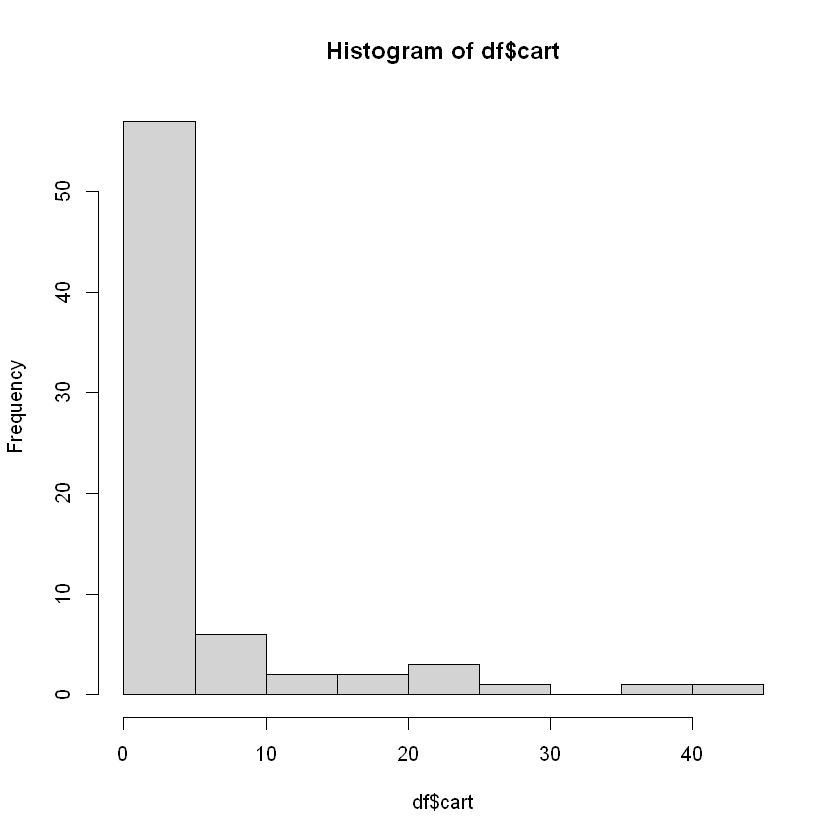

In [40]:
hist(df$cart)

In [41]:
tree.wa = tree(clusters ~ . - Country  , data = df)

In [42]:
summary(tree.wa) 


Classification tree:
tree(formula = clusters ~ . - Country, data = df)
Variables actually used in tree construction:
[1] "pcar" "mcyc" "cart" "land" "boat" "popd"
Number of terminal nodes:  10 
Residual mean deviance:  1.145 = 72.13 / 63 
Misclassification error rate: 0.2192 = 16 / 73 

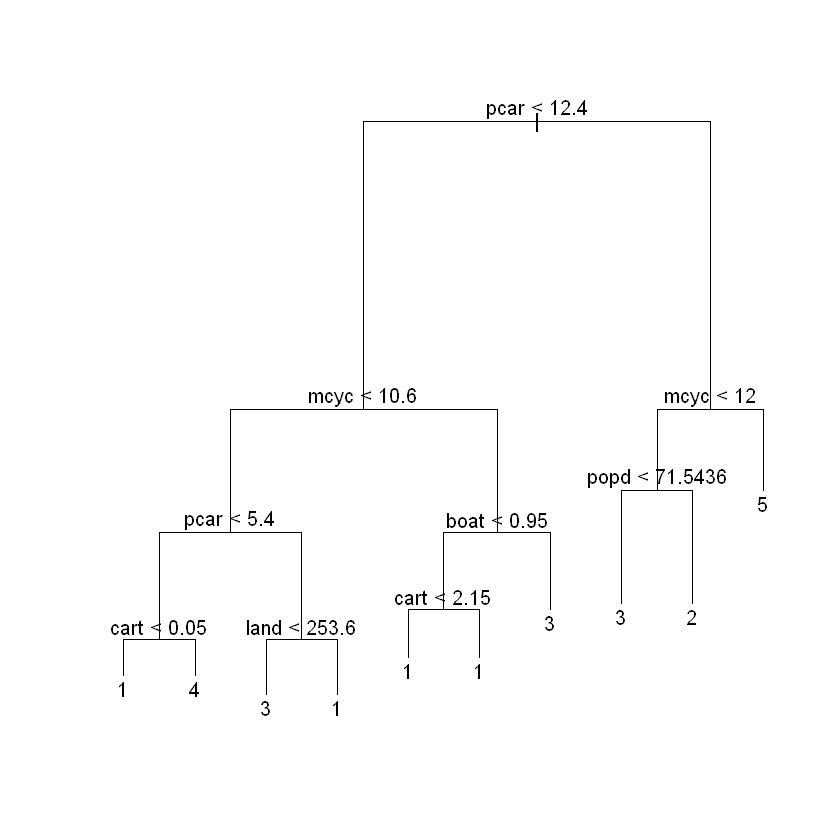

In [43]:
plot(tree.wa)
text(tree.wa, pretty = 0) #population density High density for six cluster group.

In [44]:
tree.wa

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

 1) root 73 213.500 1 ( 0.35616 0.15068 0.30137 0.10959 0.08219 )  
   2) pcar < 12.4 49 120.400 1 ( 0.53061 0.04082 0.22449 0.16327 0.04082 )  
     4) mcyc < 10.6 24  58.760 1 ( 0.33333 0.04167 0.29167 0.33333 0.00000 )  
       8) pcar < 5.4 14  24.530 4 ( 0.35714 0.00000 0.07143 0.57143 0.00000 )  
        16) cart < 0.05 5   9.503 1 ( 0.60000 0.00000 0.20000 0.20000 0.00000 ) *
        17) cart > 0.05 9   9.535 4 ( 0.22222 0.00000 0.00000 0.77778 0.00000 ) *
       9) pcar > 5.4 10  17.960 3 ( 0.30000 0.10000 0.60000 0.00000 0.00000 )  
        18) land < 253.6 5   0.000 3 ( 0.00000 0.00000 1.00000 0.00000 0.00000 ) *
        19) land > 253.6 5   9.503 1 ( 0.60000 0.20000 0.20000 0.00000 0.00000 ) *
     5) mcyc > 10.6 25  43.030 1 ( 0.72000 0.04000 0.16000 0.00000 0.08000 )  
      10) boat < 0.95 20  20.730 1 ( 0.85000 0.05000 0.10000 0.00000 0.00000 )  
        20) cart < 2.15 7  13.380 1 ( 0.57143 0.14286 

In [45]:
set.seed(101)
train = sample(1:nrow(df), 73)
head(train)

[1] 73 57 46 58 61 60

In [116]:
rf.water = randomForest(clusters~. -Country, data = df ,ntree=500,mtry=2,)
print(rf.water)


Call:
 randomForest(formula = clusters ~ . - Country, data = df, ntree = 500,      mtry = 2, ) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 17.81%
Confusion matrix:
   1 2  3 4 5 class.error
1 26 0  0 0 0  0.00000000
2  0 8  3 0 0  0.27272727
3  1 0 20 0 1  0.09090909
4  1 0  1 6 0  0.25000000
5  0 1  5 0 0  1.00000000


oob.err = double(13)
test.err = double(13)
for(mtry in 1:13){
  fit = randomForest(clusters~. -Country, data = df, subset=train, mtry=mtry, ntree = 350)
  oob.err[mtry] = fit$mse[350]
  pred = predict(fit, df[-train,])
  test.err[mtry] = with(df[-train,], mean( (clusters-pred)^2 ))
}

matplot(1:mtry, cbind(test.err, oob.err), pch = 23, col = c("red", "blue"), type = "b", ylab="Mean Squared Error")
legend("topright", legend = c("OOB", "Test"), pch = 23, col = c("red", "blue"))

In [117]:
summary(rf.water)

                Length Class  Mode     
call               6   -none- call     
type               1   -none- character
predicted         73   factor numeric  
err.rate        3000   -none- numeric  
confusion         30   -none- numeric  
votes            365   matrix numeric  
oob.times         73   -none- numeric  
classes            5   -none- character
importance        15   -none- numeric  
importanceSD       0   -none- NULL     
localImportance    0   -none- NULL     
proximity          0   -none- NULL     
ntree              1   -none- numeric  
mtry               1   -none- numeric  
forest            14   -none- list     
y                 73   factor numeric  
test               0   -none- NULL     
inbag              0   -none- NULL     
terms              3   terms  call     

The MeanDecreaseGini measures the Gini importance = how important the features are over all splits done in the tree/forest - whereas for each individual split the Gini importance indicates how much the Gini criterion = "unequality/heterogeneity" was reduced using this split.
mori, upop, pcar popd, mcyc important and contributed most to obtaining such splits, so they are considered more important.

In [118]:
importance <- importance(rf.water, sort = TRUE)
importance

,MeanDecreaseGini
bicy,2.359295
cart,2.363477
mcyc,4.041915
pcar,5.576697
boat,2.104938
wigc,2.480141
cgdp,2.441175
tpop,2.998850
upop,3.775366
popd,2.377186


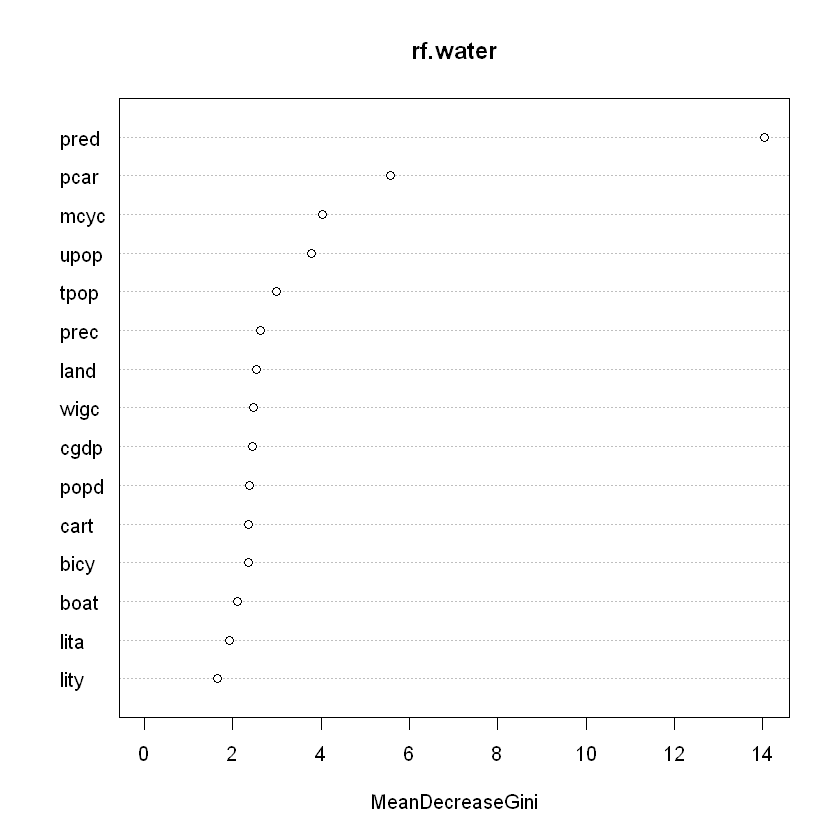

In [119]:
# create an importance plot
varImpPlot(rf.water, sort=TRUE, n.var=min(30, nrow(rf.water$importance)),
           type=NULL, class=NULL, scale=TRUE )




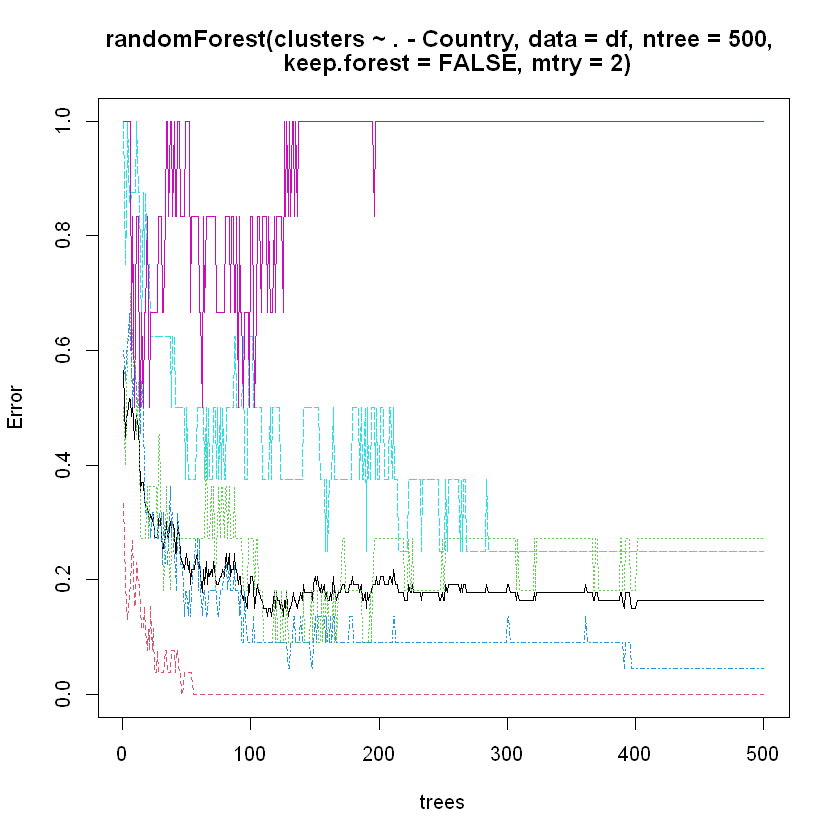

In [120]:
plot(randomForest(clusters~. -Country, data = df ,ntree=500,keep.forest=FALSE, mtry=2) )


# randomForestExplainer

In [121]:
rf.water = randomForest(clusters~. -Country, data = df ,ntree=500,mtry=2, localImp = TRUE)

In [122]:
min_depth_frame <- min_depth_distribution(rf.water)
save(min_depth_frame, file = "min_depth_frame.rda")
load("min_depth_frame.rda")
head(min_depth_frame, n = 10)

,tree,variable,minimal_depth
,<int>,<chr>,<dbl>
1,1,bicy,3
2,1,boat,3
3,1,cart,2
4,1,land,1
5,1,lita,2
6,1,lity,4
7,1,mcyc,5
8,1,pcar,0
9,1,popd,3


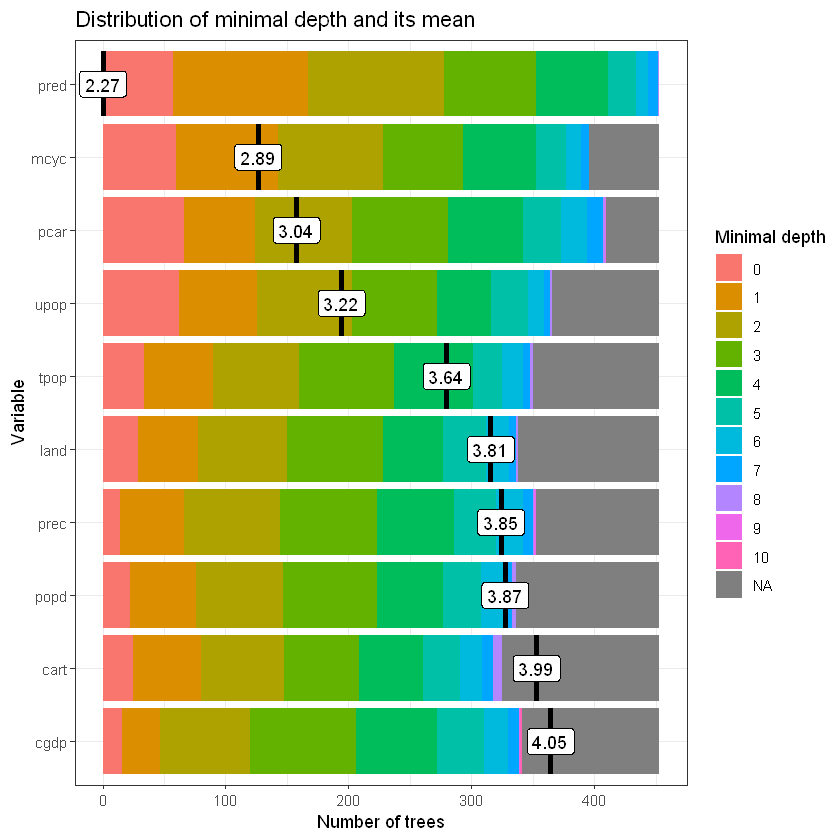

In [123]:
plot_min_depth_distribution(min_depth_frame)

The function plot_min_depth_distribution offers three possibilities when it comes to calculating the mean minimal depth, which differ in he way they treat missing values that appear when a variable is not used for splitting in a tree. They can be described as follows:

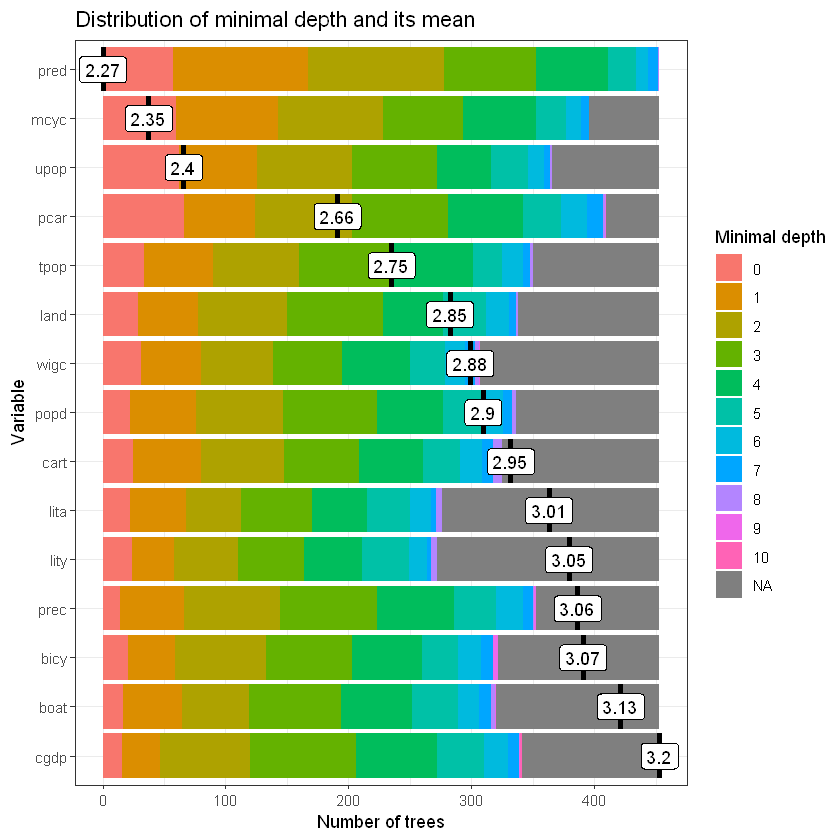

In [124]:
plot_min_depth_distribution(min_depth_frame, mean_sample = "relevant_trees", k = 15)

Clearly, using only relevant trees for calculating the mean does not change it for variables that have no missing values. Also, in this case the change does not influence the ordering of variables, but of course this usually not the case in more complex examples.

Regardless of the exact parameters used in plot_min_depth_distribution, looking at the whole distribution of minimal depth offers a lot more insight into the role that a predictor plays in a forest in contrast to looking only at the mean, especially as it can be calculated in more than one way. Additionally, the function allows us to specify the maximum number of variables plotted k, whether the values of mean minimal depth should be scaled to the [0,1] interval (mean_scale, logical), the number of digits to round the mean to for display (mean_round) and the title of the plot (main).

In [125]:
importance_frame <- measure_importance(rf.water)
save(importance_frame, file = "importance_frame.rda")
load("importance_frame.rda")
importance_frame

variable,mean_min_depth,no_of_nodes,accuracy_decrease,gini_decrease,no_of_trees,times_a_root,p_value
<fct>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>
bicy,4.105135,533,-0.0011137559,2.390882,322,21,9.971126e-01
boat,4.165382,495,0.0052409451,2.234894,320,17,9.999956e-01
cart,3.994896,526,0.0048977268,2.382750,325,25,9.989231e-01
cgdp,4.051550,587,-0.0016336398,2.445690,341,16,6.648806e-01
land,3.813002,594,0.0018450781,2.745756,338,29,5.509933e-01
lita,4.433426,383,0.0027841385,1.808436,276,22,1.000000e+00
lity,4.485488,388,0.0004637673,1.695795,272,24,1.000000e+00
mcyc,2.887024,737,0.0221264420,4.314589,396,60,4.862026e-09
pcar,3.039245,773,0.0417854761,5.713992,410,66,4.221627e-13


accuracy_decrease (classification) – mean decrease of prediction accuracy after Xj is permuted,

gini_decrease (classification) – mean decrease in the Gini index of node impurity (i.e. increase of node purity) by splits on Xj,

mse_increase (regression) – mean increase of mean squared error after Xj is permuted,

node_purity_increase (regression) – mean node purity increase by splits on Xj, as measured by the decrease in sum of squares,

mean_minimal_depth – mean minimal depth calculated in one of three ways specified by the parameter mean_sample,

no_of_trees – total number of trees in which a split on Xj occurs,

no_of_nodes – total number of nodes that use Xj for splitting (it is usually equal to no_of_trees if trees are shallow),

times_a_root – total number of trees in which Xj is used for splitting the root node (i.e., the whole sample is divided into two based on the value of Xj),

p_value – p-value for the one-sided binomial test using the following distribution:

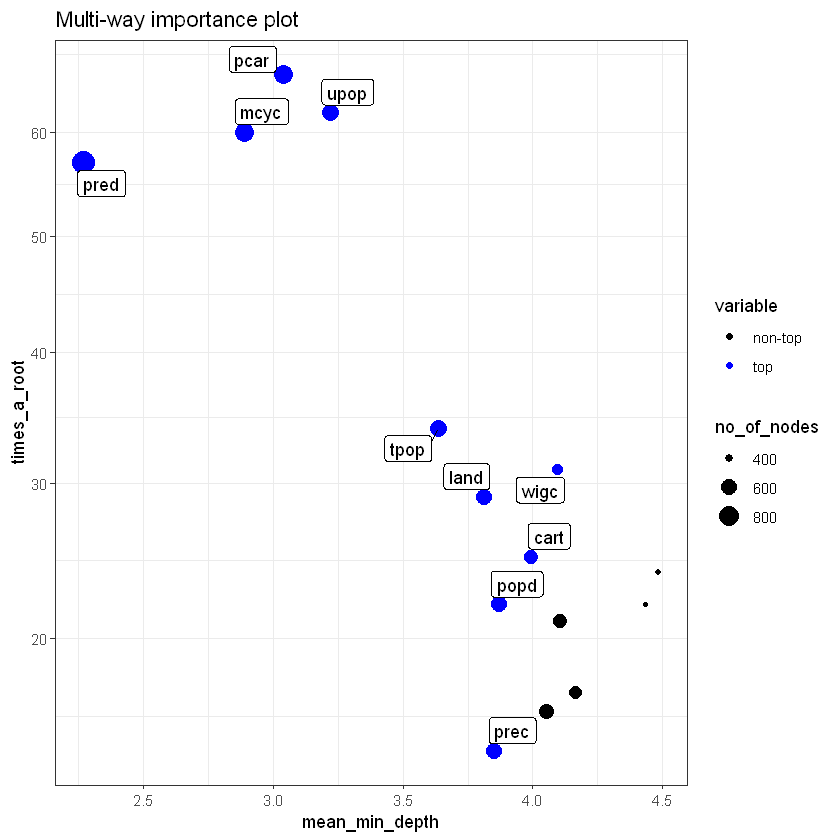

In [126]:
plot_multi_way_importance(importance_frame, size_measure = "no_of_nodes")

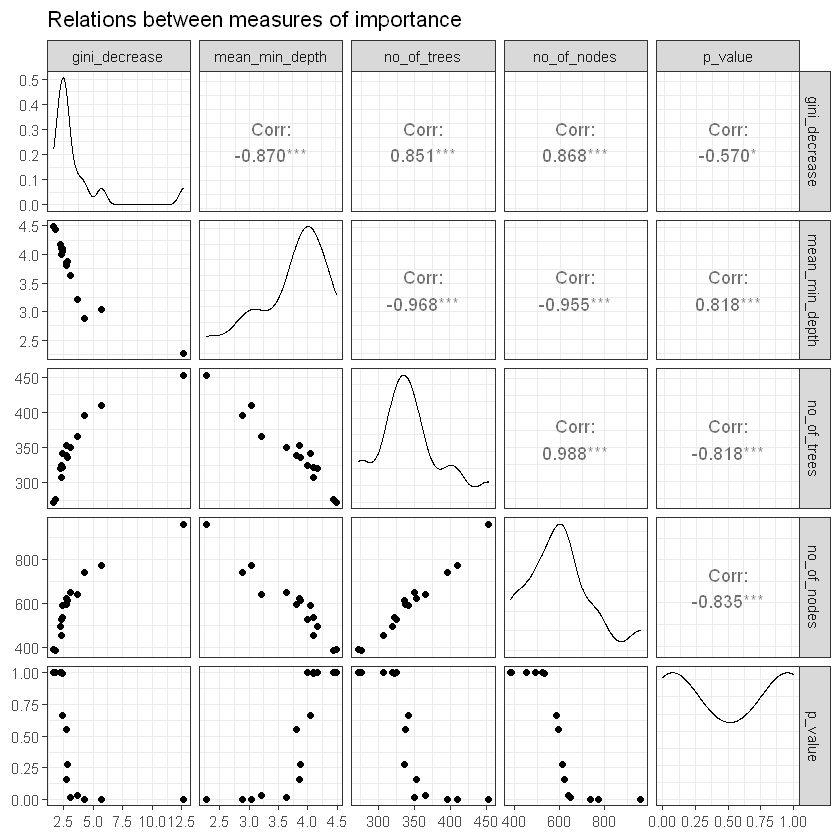

In [128]:
plot_importance_ggpairs(importance_frame)

We can see that all depicted measures are highly correlated (of course the correlation of any measure with mean minimal depth is negative as the latter is lowest for best variables), but some less than others. Moreover, regardless of which measures we compare, there always seem to be two points that stand out and these most likely correspond to lstat and rm (to now for sure we could just examine the importance_frame).

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



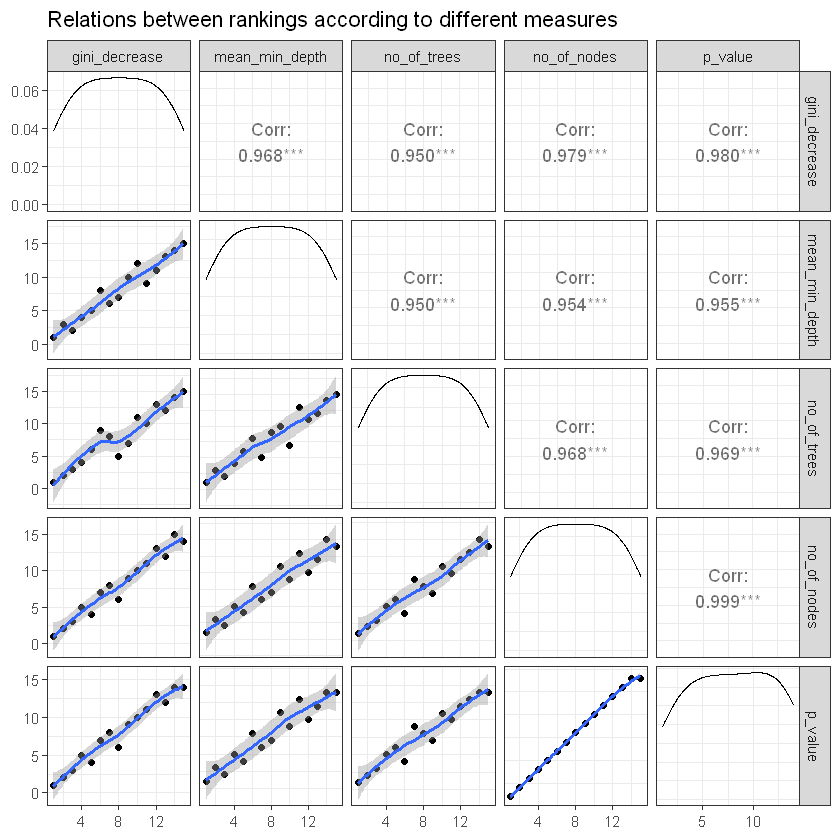

In [129]:
plot_importance_rankings(importance_frame)

In [ ]:
The above density estimates show that skewness was eliminated for all of our importance measures (this is not always the case, e.g., when ties in rankings are frequent, and this is likely for discrete importance measures such as times_a_root, then the distribution of the ranking will also be skewed).

# Confusion Matrix

In [51]:
df$pred <- predict(rf.water , df)
df$pred <- as.factor(df$pred)
confusionMatrix(df$pred, df$clusters)

Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4  5
         1 26  0  0  0  0
         2  0 11  0  0  0
         3  0  0 22  0  0
         4  0  0  0  8  0
         5  0  0  0  0  6

Overall Statistics
                                     
               Accuracy : 1          
                 95% CI : (0.9507, 1)
    No Information Rate : 0.3562     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5
Sensitivity            1.0000   1.0000   1.0000   1.0000  1.00000
Specificity            1.0000   1.0000   1.0000   1.0000  1.00000
Pos Pred Value         1.0000   1.0000   1.0000   1.0000  1.00000
Neg Pred Value         1.0000   1.0000   1.0000   1.0000  1.00000
Prevalence             0.3562   0.1507   0.3014   0.1096  0.08219
Detection 

In [52]:
pred <- predict(object = rf.water,
            newdata = df,
            type = "prob")
for (i in 1:5) {
auc <-    auc(actual = df$clusters, 
    predicted = pred[,i])
print(auc(actual = df$clusters, 
    predicted = pred[,i]))
    }

[1] 1
[1] 0.2336334
[1] 0.1599836
[1] 0.5883797
[1] 0.3134206


AUC is intended to determine the degree of separability, or the ability to correct predict class. The higher the AUC the better. 1 would be perfect, and .5 would be random.